# Water security project for Modern Data Analytics 

In the following code cell I will import all the necessary packages

In [55]:
# Data processing
import matplotlib.pyplot as plt
import requests
import pandas as pd
import re

# Models
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import graphviz
from graphviz import Source

import enchant
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


## 1. United Nations UN water data

#### 1.1 Data fetching

Using the United Nations Water webpage, we can build a dataframe that brings global indicators regarding social, economical and enviromental indicators. Even if the webpage is itself an interactive map, we can make use of the API that the browser uses to get the data. By taking a look at how the browser would make use of the API, we would do it the same way by changing some parameters. Later, we would analyze the data using the tools reviewed in the lectures

In [56]:
# 6.1.1 Proportion of population using safely managed drinking water services
url = "https://www.sdg6data.org/handle-ajax-callback"

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:103.0) Gecko/20100101 Firefox/103.0",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
    "X-Requested-With": "XMLHttpRequest",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin"
}

indicators = [
    ("79_80", "0.00", "3,850.49", "stress"),  # Water stress
    # Renewable water resources in billion cubic meters per year
    ("135_137_138", "0.00", "8,647.00", "renewable"),
    # Degree of integrated water resources management implementation (0-100)
    ("82_83", "0.00", "100.00", "mngmt"),
    # Gross domestic product per capita
    ("483_508", "731.06", "112,226.90", "gdp"),
    # Proportion of population with access to electricity
    ("483_503", "0.00", "100.0", "elec"),
    ("485_499", "0.00", "100.00", "agr"),  # Agricultural land (% of land area)
    # CO2 emissions, tonnes per capita
    ("485_501", "0.00", "33.75", "emission")
]


The following function will receive 4 arguments to build a __df__. It will create the _body_ needed for the request and it will return the __df__ with the information by country

In [57]:
def generate_df(indicator, min_bound, max_bound, col_name):
    r"""
    So after taking a look at the API that the UN Water uses to get the data, it asks for the values regarding the locations, the number of the indicator and the ranges.
    Given that the URL and the headers are the same, there are a few parameters that change between each request

    Keyword arguments:
    indicator -- is like the id of the indicator desired to be fetch
    min_bound -- is the minimum value possible to get. In the website it is possible to filter by this value
    max_bound -- is the maximum value possible to get. In the website it is possible to filter by this value
    col_name -- is the name of the column in the pd.DataFrame
    """

    body = f"allRegion%5B%5D=World--World&allRegion%5B%5D=Geographical+region--Latin+America+and+the+Caribbean&allRegion%5B%5D=Geographical+region--Asia&allRegion%5B%5D=Geographical+region--Europe&allRegion%5B%5D=Geographical+region--Northern+Africa&allRegion%5B%5D=Geographical+region--Northern+America&allRegion%5B%5D=Geographical+region--Oceania&allRegion%5B%5D=Geographical+region--Sub-Saharan+Africa&indicators%5B%5D={indicator}&ranges%5B0%5D%5B%5D={min_bound}&ranges%5B0%5D%5B%5D={max_bound}"
    req = requests.post(url, headers=headers, data=body)
    data = req.json()["commonCountriesDataTable"]
    df = pd.DataFrame()
    df["country"] = data.keys()
    df[col_name] = data.values()
    return df


_indicators_ will be looped using the function created and it will be joined to a first __df__ created using the _water stress_ variable given that it is an important variable for the analysis. The result will be a dataframe with 9 variable of 179 countries

In [58]:
ind, min, max, col_name = indicators[0]
df = generate_df(ind, min, max, col_name)

for ind, min, max, col_name in indicators[1:]:
    df_1 = generate_df(ind, min, max, col_name)
    df = pd.merge(df, df_1, how="left", on=["country", "country"])


After fetching the data, we look at the dataset to see the variables, its type and how many missing values are in each column.

In [59]:
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    179 non-null    object
 1   stress     179 non-null    object
 2   renewable  177 non-null    object
 3   mngmt      170 non-null    object
 4   gdp        174 non-null    object
 5   elec       178 non-null    object
 6   agr        178 non-null    object
 7   emission   177 non-null    object
dtypes: object(8)
memory usage: 12.6+ KB


(None,
   country    stress renewable  mngmt        gdp    elec    agr emission
 0     AFG     54.76     65.33  12.00   1,970.56   97.70  58.08     0.20
 1     AGO      1.87    148.40  61.00   6,110.27   45.67  45.68     0.89
 2     ALB      6.80     30.20  47.00  13,192.44  100.00  42.85     1.94
 3     ARE  1,630.67      0.15  79.00  63,299.42  100.00   5.38    20.80
 4     ARG     10.46    876.20  38.00  19,690.66  100.00  54.36     3.99)

Using the _info_ function, we can see that all the columns are type object, so it is necessary to convert to numeric. Also, for 3 variables de thousands separator should be removed. Also, we can see that the variables do not have considerable missing values, so it is easier to assess this issue with data imputation

In [60]:
# Cast the variables as float except the country
for col in df.columns[1:]:
    if col in ["stress", "renewable", "gdp"]:
        df[col] = df[col].str.replace(',', '').astype(float)
    else:
        df[col] = df[col].astype(float)


In [61]:
# Fill in the missing values using the mean of the column
for col in df.columns[2:]:
    df[col] = df[col].fillna(df[col].mean())


In [62]:
# To determine a high index of water stress, a threshold of 40% has been arbitrarily chosen amongst the scientific water resources modelling community. This will be our target variable in our model
# https://rdmc.nottingham.ac.uk/bitstream/handle/internal/188/Geography%20sustainability.old/23_how_can_water_stress_be_calculated.html

df["high"] = df["stress"] > 40


#### 1.2 Model

Based on our research question, the goal is to understand the factors that would lead to a high water stress index on how a country can prevent it from beign in such a situation. First, we will fit a decision tree to try to understand the factors that can lead to a high stress indicator

In [89]:
# First define X and Y data to fit the model. We take the independent columns that we think might determine the water stress.
X = df.iloc[:, 2:8].values
y = df["high"]

# Create and instance of a decision tree and fit the model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)


In [90]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df.columns[2:8],
                                class_names=["high", "low"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = Source(dot_data)
graph.format = 'png'
graph.render('water_stress_tree', view=True)


'water_stress_tree.png'

From the tree, we can see that the amount of water resources is key to have a low water stress index. This is one of the most important advantage of decision tress, that they are easy to interpret. For example, if a country gets below 5.31 billion cubic metric of renewable water resources, it will be an indication that it might get high water stress problem. But it is now the only indicator, even if it has high water resources, it needs to have a not to high gpd, probably because more production needs more water and that could lead to water depletion, and so on. Also having low proportion of agricultural land is an indicator of low water stress. That can be explained by the amounts of water needed to feed animals used for production.

Now we have an idea of what can determine a high water stress, but it necessary to know how good the model performs. For this, we will apply a train-test split to assess the accuracy of the model. With the train data we will generate the tree and with the test we will predict for new data and see how well it does

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

# Create Decision Tree classifer object
clf = tree.DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7037037037037037


It seems that the accuracy is not too bad for new data, but we can improve the model by using a differente creiterion than _gini_, so we will try _entropy_, and to restrict the depth of the tree so we can get a less overfitted model

In [93]:
# Create Decision Tree classifer object
clf_opt = tree.DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Train Decision Tree Classifer
clf_opt = clf_opt.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf_opt.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7407407407407407


This last tree seems to be doing pretty well, and we can see that some variable like _gdp_ are not that important compared to the tree without validation. This last tree is quite easy to understand and to get insights, which can help to understand and classify when a country has high water stress

In [88]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df.columns[2:8],
                                class_names=["high", "low"],
                                filled=True, rounded=True,
                                special_characters=True)

graph = Source(dot_data)
graph.format = 'png'
graph.render('water_stress_tree_opt', view=True)


'water_stress_tree_opt.png'

Although, decision trees can be biased and sensitive to variations, so to try to improve the model some options are available to reduce the variance and the bias. To get a better model, we will implement a random forest and boosting models. The advantage of this models is that they are based on decision trees, so the approach is similar and can generate better results given its robustness and accuracy, but the problem is that the interpretation is not that easy as a single tree and it can be slow to compute

First, we fit the random forest

In [97]:
# Create a Gaussian Classifier
rf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=rf.predict(X_test)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8148148148148148


One of the advantages of random forests is that we can see how important is each feature by taking a look at the node impurity decrease averaged over all trees of the ensemble. From the importance score index, as we saw in the optimized decision tree, we can see the amount of renewable resources and the proportion of land used in agriculture are important to determine a high level of water stress.

In [100]:
feature_imp = pd.Series(rf.feature_importances_,
                        index=df.columns[2:8]).sort_values(ascending=False)
feature_imp


renewable    0.249369
agr          0.190578
emission     0.167606
gdp          0.157641
mngmt        0.136132
elec         0.098674
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


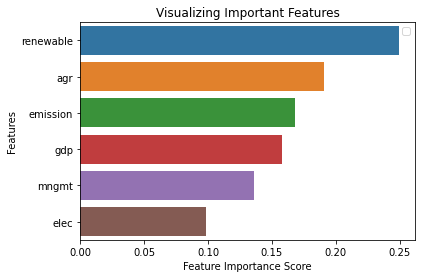

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


By determining the most important features in a random forest ensemble, we can fit a model with the top features and see if the accuracy can be improved

In [106]:
X_feat = df[['renewable', 'agr', 'emission']]  # Removed feature "sepal length"
y_feat = df['high']

# Split dataset into training set and test set
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, test_size=0.70, random_state=5)  # 70% training and 30% test


In [105]:
from sklearn import metrics
clf_feat = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_feat.fit(X_train_feat, y_train_feat)

# prediction on test set
y_pred_feat = clf_feat.predict(X_test_feat)

# Import scikit-learn metrics module for accuracy calculation
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test_feat, y_pred_feat))


Accuracy: 0.7857142857142857


Unfortunately, the metric is not improving but decreasing, so its better to use the first random forest estimated
Now we will try gradient boosting. This approach train a decision tree and based on the results it trains a second tree to try to improve the metrics. Like Random Forests, it uses many trees but a difference is that this approach is better at reducing the bias, meanwhile Random Forests is better at reducing variance. After fitting the model we its clear that the performance is not too good, and that using a random forest is a better approach.

In [108]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)


0.6851851851851852

#### 1.3 Conclusion

In order to determine what can cause a high water stress index, we collected data from the UN Water database for 2019 and analyzed it using decision trees approach. We started using a single tree to see what are the most relevant factors, and later we implemented ensemble models like random forests and gradient boosting. Based on the metrics, it is clear that the RF approach was better in generalizing new data and it was a more robust approach than using a single tree.

From our analysis, we can see that mantaining healthy water resources management, not using too much of agrucltural land and limiting the national production can be a way to maintain a low water stress index.

## 2. Water stress risks using CDP data

The next part of the analysis is to determine what are the common risks regarding water stress that a city may encouter. For this, we will use the Climate Disclosure Panel (CDP) database where it is possible to find information about environmental impacts. We will use the 2018 Cities Water Risks dataset which is a questionnaire about risks to water supply. From the webopage, we can download a csv file with the data

2.1 Data preparation

In [41]:
## Load the data with pandas

# df_2017_risk = pd.read_csv("data/2017_Cities_Water_Risks.csv")
df_2017_risk = pd.read_csv("data/2017_Cities_Water_Risks.csv")
# df_2017_actions = pd.read_csv("data/2017_-_Cities_Water_Actions.csv")
# df_2018_actions = pd.read_csv("data/2018_-_Cities_Water_Actions.csv")
df_2017_risk.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Account No                    709 non-null    int64 
 1   Organisation                  709 non-null    object
 2   City                          709 non-null    object
 3   Country                       709 non-null    object
 4   Region                        709 non-null    object
 5   Access                        709 non-null    object
 6   C40                           172 non-null    object
 7   Reporting year                709 non-null    int64 
 8   Risks to city’s water supply  709 non-null    object
 9   ​Timescale                    673 non-null    object
 10  Magnitude                     686 non-null    object
 11  Risk description              594 non-null    object
 12  Current population            709 non-null    int64 
 13  Population year     

The dataset consists of 15 columns with information regarding the city, the type of risk and details about th risk. Our target column is the Risk decription, but first we need to filter the risks regarding water stress and remove the columns that do not contain any information

In [42]:
df_2017_risk["Risks to city’s water supply"].unique()

array(['Flooding', 'Higher water prices',
       'Increased water stress or scarcity',
       'Inadequate or aging infrastructure', 'Declining water quality',
       'Water losses', 'Other', 'Regulatory', 'Other '], dtype=object)

In [43]:
# First remove the columns without information
df_notna = df_2017_risk[pd.isna(df_2017_risk["Risk description"])==False]

# Get the descriptions of the risks for water stress
target_text = df_notna[df_notna["Risks to city’s water supply"] == "Increased water stress or scarcity"]["Risk description"].unique()

By taking a look at the data, for some cities the text is not in english, so it is possible that we will loose some data. Still, with the _enchant_ package we can filter the data that is not in english. We will go to each word and if more than 75% of the words are in english then the text will be considered to be in english.

In [30]:
dictionary = enchant.Dict("en_US")

def is_english(text):
    count = 0
    words = text.split()

    max_count = len(words)
    for word in words:
        if dictionary.check(word):
            count += 1
    if count/max_count > .75:
        return True
    return False


In [44]:
english_text = [text for text in target_text if is_english(text)]
print(f"The percentage of english text according to the filter is {len(english_text)/len(target_text)}")

The percentage of english text according to the filter is 0.7960199004975125


Now we will proceed to analysis this unstructure data. The tool chosen for the job is the _nltk_ library, which is a platform to use over 50 lexical libraries for  classification, tokenization, stemming, tagging, parsing, and semantic reasoning. With this library we can preprocess the text, analyze it and create useful visualizations

The first step will be to tokenize the data. This way we can work with the text in smaller pieces that are coherent and is easier to try to make sense of it. Also in order to clean the data we will remove all punctuation makrs given that this not meaningfull for the analysis. Also with the use of regular expressions we can remove urls and line jumps

In [60]:
nltk.download("punkt")

tokenized_words = []
for text_list in  [word_tokenize(x) for x in english_text]:
    text_list = tokenized_words.extend([word for word in text_list if word.isalnum()])

tokenized_words[:30]

[nltk_data] Downloading package punkt to
[nltk_data]     /home/juanjosebuitrago/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Extreme',
 'rains',
 'may',
 'cause',
 'basement',
 'flooding',
 'Managing',
 'water',
 'use',
 'Changes',
 'in',
 'seasonality',
 'how',
 'and',
 'when',
 'Calgary',
 'receives',
 'precipitation',
 'will',
 'change',
 'how',
 'water',
 'is',
 'managed',
 'and',
 'storage',
 'will',
 'become',
 'more',
 'critical']

Looks like our data is almost ready to be analyzed. From the small sample above, we can see som words like _is_, _and_, _in_ that are commonly used words in any scenario. The most common are determiners like _the_, _and_, _a_ and so on, conjunctions like _for_, _nor_, _or_, and prepositions like _in_ or _before. This are called stop words. This words should be removed basically because this way we can focus on relevant words for our analysis. We can also customize this set by adding words like _water_ or _stress_ which we know are going to appear in the text

In [124]:
nltk.download("stopwords")
from nltk.corpus import stopwords

my_stopwords = stopwords.words("english")
my_stopwords.extend(["water", "stress"])
stop_words = set(my_stopwords)
filtered_words = [word for word in tokenized_words if word.casefold() not in stop_words]

filtered_words[:30]



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juanjosebuitrago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Extreme',
 'rains',
 'may',
 'cause',
 'basement',
 'flooding',
 'Managing',
 'use',
 'Changes',
 'seasonality',
 'Calgary',
 'receives',
 'precipitation',
 'change',
 'managed',
 'storage',
 'become',
 'critical',
 'Climate',
 'change',
 'need',
 'considered',
 'assess',
 'adequacy',
 'existing',
 'efficiency',
 'targets',
 'long',
 'time',
 'goes']

Also, another NLP technique to be considered is __lemmatizing__ which is basically take the words to its root. For example, _city_ and _cities_ means the same, so this way we can use the words in it's basic meaning rather than in the context of how it is beign used. A first techinque to be considered could have been __stemming__, but it may be inconsistent. The advantage of using __lemmatizing__ is that it will reduce the word to its core and also gives an english meaning as a result

In [125]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

lemmatized_words[:30]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/juanjosebuitrago/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/juanjosebuitrago/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['Extreme',
 'rain',
 'may',
 'cause',
 'basement',
 'flooding',
 'Managing',
 'use',
 'Changes',
 'seasonality',
 'Calgary',
 'receives',
 'precipitation',
 'change',
 'managed',
 'storage',
 'become',
 'critical',
 'Climate',
 'change',
 'need',
 'considered',
 'ass',
 'adequacy',
 'existing',
 'efficiency',
 'target',
 'long',
 'time',
 'go']

Finally, there are few words that contain numbers and some other words like _Vandværk_ are in the corpus. With the use of regular expressions this words will be removed and also all words will be in lower case

In [126]:
final_words = [word.lower() for word in lemmatized_words if bool(re.match(r"[a-zA-Z]", word))]

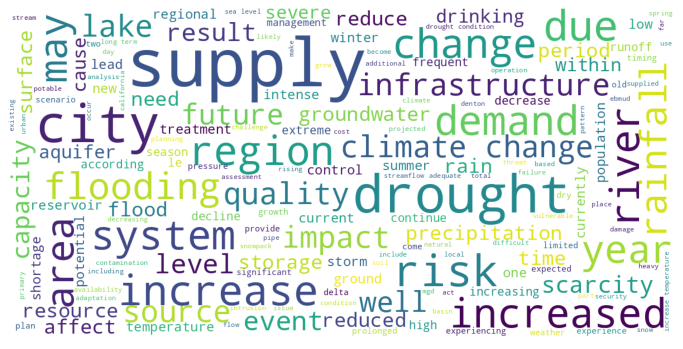

In [127]:
# Create and generate a word cloud image
words_string = " ".join(final_words)

wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=1  # chosen at random by flipping a coin; it was heads
).generate(words_string)

# Display the generated image:
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
# if title:
#     fig.suptitle(title, fontsize=20)
#     fig.subplots_adjust(top=2.3)

plt.imshow(wordcloud)
plt.show()
